# BT2 - RANSAC y Transformada de Hough

## Autores

* **Juan Diego Gallego Nicolás (jdiego.gallego@um.es)**
* **Óscar Vera López (oscar.veral@um.es)**
  
## Fecha

**27 de Octubre de 2025**

***

## Índice

### 1. Introducción al notebook

### 2. Configuración e inicialización

* 2.1. Importación de librerías
* 2.2. Definición de funciones auxiliares
* 2.3. Presentación y preprocesado de las imágenes

### 3. Detección de bordes

### 4. Detección de rectas

* 4.1. Implementación y aplicación de **RANSAC** para rectas
* 4.2. Implementación y aplicación de **Transformada de Hough** para Rectas

### 5. Detección de polígonos

### 6. Detección de circunferencias

* 6.1. Implementación y aplicación de **RANSAC** para rectas
* 6.2. Implementación y aplicación de **Transformada de Hough** para Rectas

### 7. Comparaciones con OpenCV

### 8. Puntos aplicados y conclusiones

### Uso de IA

### Bibliografía

***

# 1. Introducción al notebook

Este notebook es la segunda parte de una serie de cinco que constituye nuestra práctica para la asignatura de Visión Artificial del Máster en Inteligencia Artificial de la Universidad de Murcia. Alguno de los métodos/resultados que aquí se utilizan pueden estar comentados en un notebook anterior. Para el correcto funcionamiento del mismo es necesario instalar el paquete del proyecto siguiendo las instrucciones del [repositorio de GitHub]{https://github.com/oscarveral/vision.git}.

Aquí tratamos la detección de rectas y de otras formas geométricas características en el ámbito de las señales de tráfico, candidatas idóneas sobre el papel para aplicar las técnicas vistas en la asignatura. Comenzamos presentando el conjunto de imágenes que servirán como objeto para la aplicación de **RANSAC** (Random Sample Consensus) y la **HT** (Hough Transform). Seguidamente pasamos a la preparación y transformación de las imágenes, principalmente mediante la aplicación del **filtro de Canny** implementado en el notebook BT1 para la detección de bordes. Los siguientes puntos contienen la explicación y aplicación de nuestras implementaciones de RANSAC y HT aplicadas al dataset procesado. A contrinuación, comparamos nuestros resultados con los que obtiene otra libería estandarizada.

Al final del documento, incluimos un apartado de conclusiones y justificación de los ítems de bloques cubiertos por nuestro trabajo. También dejamos un párrafo explicando el papel de la IA generativa en la elaboración del mismo.

# 2. Configuración e inicialización

## 2.1. Importación de librerías

En el siguiente fragmento de código se incluyen las importaciones necesarias para la ejecución de todos los bloques de código del notebook. Recuerde crear un entorno virtual con el proyecto instalado (Ejecutar "pip install -e ." en el directorio raíz del proyecto).

In [1]:
# Imports de python

# Librerías de terceros
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


# Librerías propias
from dgst.utils.loader import *
from dgst.utils.processor import *


## 2.2. Definición de funciones auxiliares

In [2]:
# Función para mostrar las imágenes en una cuadrícula
def plot_images(images, titles=None, grid_shape=(3, 4)):
    fig, axes = plt.subplots(*grid_shape, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            if (isinstance(images[i], np.ndarray)):
                ax.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
            else:
                ax.imshow(cv.cvtColor(images[i].data, cv.COLOR_BGR2RGB))
            if titles:
                ax.set_title(titles[i])
            else:
                ax.set_title(f'Image {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## 2.3. Presentación y preprocesado de las imágenes

Hemos seleccionado un subconjunto de 12 imágenes del dataset presentado en el notebook BT0. En todas las imágenes aparecen señales de tráfico con diferentes geometrías, algunas más cercanas a la cámara y otras más alejadas. Las encontramos dentro de la carpeta '/images/bt2'.



Loading image from ./images/bt2/000014/camera_front_blur/000014_india_2021-04-18T15:57:58.885517Z.jpg
Loading image from ./images/bt2/000177/camera_front_blur/000177_golf_2021-04-26T09:01:16.995578Z.jpg
Loading image from ./images/bt2/000205/camera_front_blur/000205_india_2021-04-29T13:26:40.774894Z.jpg
Loading image from ./images/bt2/000247/camera_front_blur/000247_golf_2021-04-27T10:58:38.108810Z.jpg
Loading image from ./images/bt2/020539/camera_front_blur/020539_india_2020-04-24T13:34:24.775134Z.jpg
Loading image from ./images/bt2/020541/camera_front_blur/020541_india_2020-03-31T11:09:20.113995Z.jpg
Loading image from ./images/bt2/020567/camera_front_blur/020567_india_2020-07-27T13:01:18.890907Z.jpg
Loading image from ./images/bt2/020578/camera_front_blur/020578_oscar_2021-04-15T08:41:33.109881Z.jpg
Loading image from ./images/bt2/020579/camera_front_blur/020579_india_2020-07-22T08:47:24.215579Z.jpg
Loading image from ./images/bt2/020604/camera_front_blur/020604_golf_2021-02-23T14:0

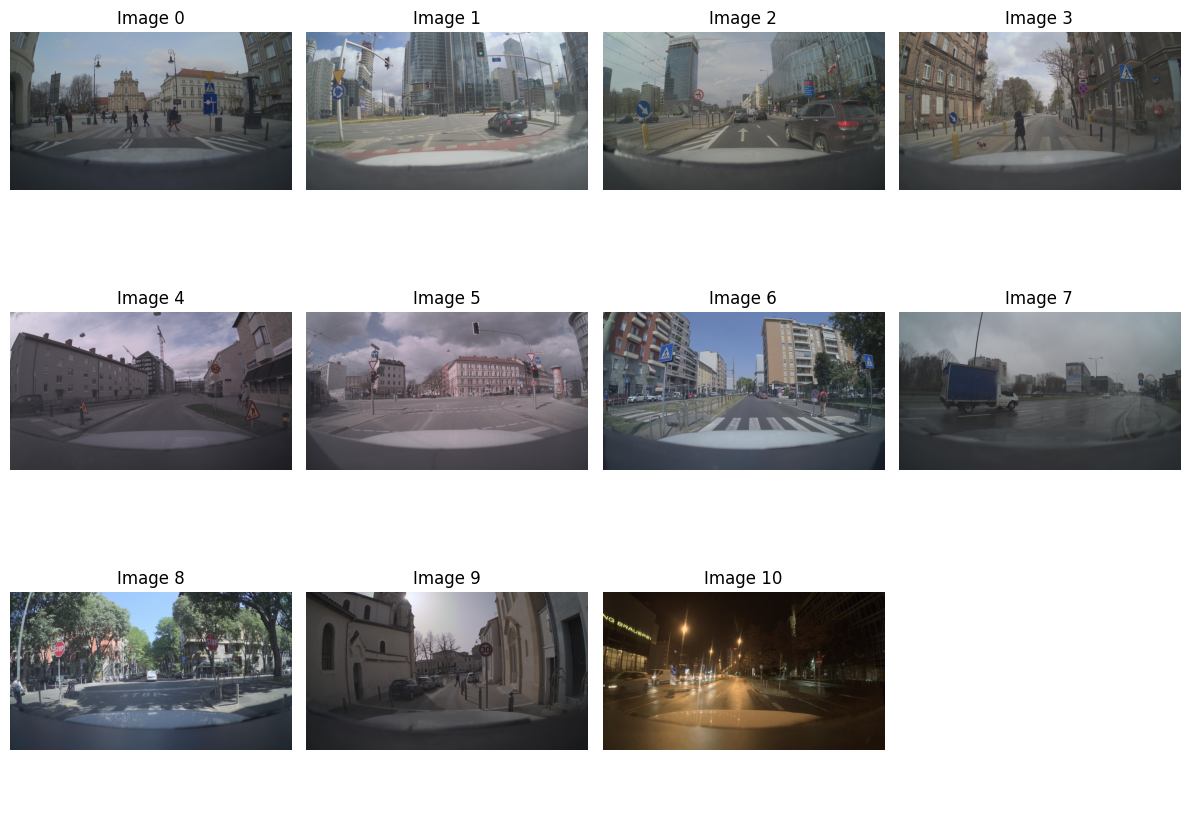

In [3]:
data_loader = DataLoader('./images/bt2')
images = []
for idx in [14, 177, 205, 247, 20539, 20541, 20567, 20578, 20579, 20604, 30352]:
    image = data_loader.load(idx)
    images.append(image)

plot_images(images, grid_shape=(3, 4))

Como observamos, las imágenes sufren de una acusada distorsión de ojo de pez que ya comentamos en el notebook anterior. Este fenómeno dificultaría enormemente la aplicación de técnicas clasicas de detección de rectas. Por tanto, aplicamos el algoritmo de rectificación.

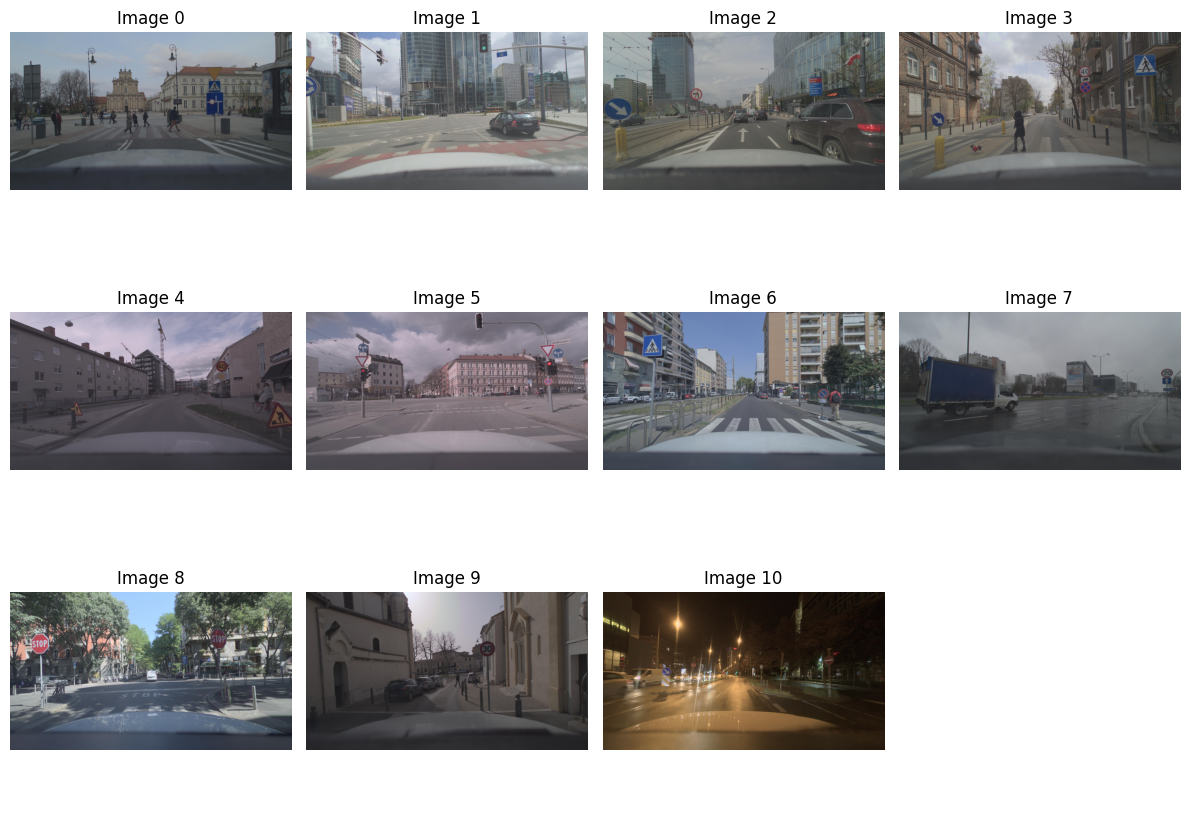

Cada imagen rectificada tiene un tamaño de: (2168, 3848, 3)


In [4]:
# Rectificamos las imágenes
rectified_images = []
for image in images:
    processor = ImageProcessor().add_kannala_brandt_undistortion(image.calibration)
    rectified_image = processor.process(image.data)
    rectified_images.append(rectified_image)

# Mostramos las imágenes rectificadas
plot_images(rectified_images, grid_shape=(3, 4))
print("Cada imagen rectificada tiene un tamaño de:", rectified_images[0].shape)

El efecto es evidente, por ejemplo, en el salpicadero del coche. Otra consecuencia del filtro es la desaparición de los bordes de la imagen, aunque la resolución de las mismas se mantiene. Para verlo en mayor detalle:

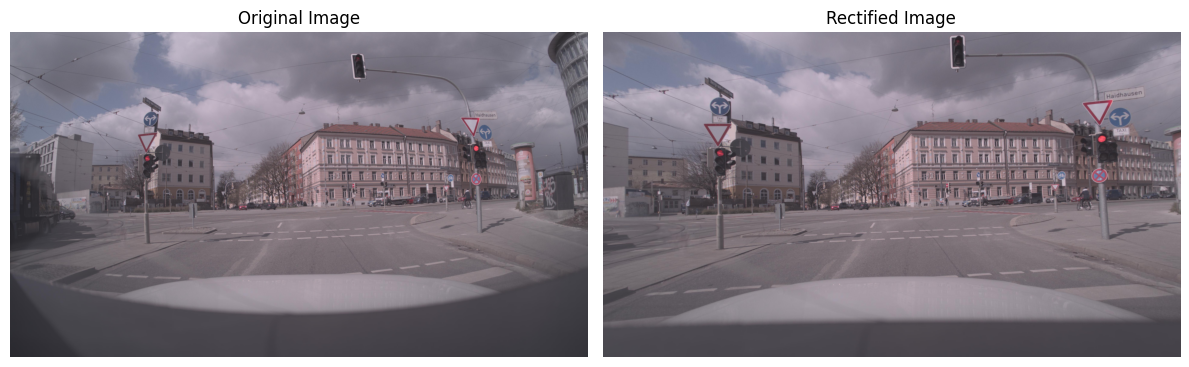

In [5]:
plot_images([images[5].data, rectified_images[5]], titles=['Original Image', 'Rectified Image'], grid_shape=(1, 2))

Como vamos a trabajar a partir de ahora con las imágenes rectificadas, borramos la lista original para liberar espacio.

In [6]:
del images

# 3. Detección de bordes

Antes de aplicar cualquier algoritmo de detección de formas geométricas es necesario usar en primer lugar un filtro de detección de bordes. El detector de bordes de Canny ([Canny, J. (1986)](https://doi.org/10.1109/TPAMI.1986.4767851)) es la herramienta más extendida en este ámbito dada su base matemática y su efectividad. En este notebook vamos a usar la implementación propia que comentábamos en el previo BT1. Como indicábamos, esta implementación comienza desde la aplicación del filtro de Sobel para el cálculo de las derivadas direccionales y no aplica el filtro de suavizado previo. En la documentación de [OpenCV](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) no queda claro en qué magnitud aplica el filtro gaussiano, así que nosotros vamos a utilizar un kernel de $\sigma=1.4$ ya que es el que mejor nos funciona.


In [7]:
import traceback

canny_processor = (ImageProcessor()
    .add_grayscale()
    .add_gaussian_filter(sigma=1.4)
    .add_canny_edge_detection(low_threshold=100, high_threshold=200)
)

img = rectified_images[0]
print("type:", type(img))
print("shape, dtype, min, max:", getattr(img, "shape", None), getattr(img, "dtype", None), img.min(), img.max())

try:
    out = canny_processor.process(img)
    print("processed OK ->", type(out), getattr(out, "shape", None), getattr(out, "dtype", None))
except Exception as e:
    traceback.print_exc()

: 

## Bibliografía

- [Canny, J. (1986)](https://doi.org/10.1109/TPAMI.1986.4767851). *A Computational Approach to Edge Detection.* **IEEE Transactions on Pattern Analysis and Machine Intelligence**, vol. PAMI-8, no. 6, pp. 679–698, Nov. 1986.
